# Probability and Statistics for Data Science

https://uodsci.github.io/dsci345

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd

This is here so we can use `\P` and `\E` in LaTeX below.
$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}}$$

# Uncertainty: (how to) deal with it

When we're doing data science, we

- look at data
- make predictions about future values
- infer aspects of the underlying process

Fundamental to all stages are *randomness* and *uncertainty*.

*For instance:*

Computing **a statistic**
gives you a number that describes a data set.

**Doing statistics** helps you understand
how reliable that description is
and how well it applies to the wider world.

We understand uncertainty, conceptually and quantitatively,
with **randomness**,

i.e., through *probability*.

## Goals of this class

- Become familiar with different types of probability models.

- Calculate properties of probability models.

- Construct and simulate from realistic models of data generation.

- Be able to test estimation and prediction methods with simulation.

- Gain familiarity with fundamental statistical concepts.

We'll spend a lot of time on *probability models*,
for applications from classical statistics
to machine learning.

Course mechanics: https://uodsci.github.io/dsci345

(break: fill out the survey)

# Getting random

**Today:** *Probability and expectation, conditional probabilities, and random variables.*

First:
let's get some [(pseudo-)randomness](https://numpy.org/doc/stable/reference/random/generator.html).

In [3]:
rng = np.random.default_rng()
help(rng.random)

Help on method random in module numpy.random._generator:

random(size=None, dtype=<class 'numpy.float64'>, out=None) method of numpy.random._generator.Generator instance
    random(size=None, dtype=np.float64, out=None)

    Return random floats in the half-open interval [0.0, 1.0).

    Results are from the "continuous uniform" distribution over the
    stated interval.  To sample :math:`Unif[a, b), b > a` use `uniform`
    or multiply the output of `random` by ``(b - a)`` and add ``a``::

        (b - a) * random() + a

    Parameters
    ----------
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    dtype : dtype, optional
        Desired dtype of the result, only `float64` and `float32` are supported.
        Byteorder must be native. The default value is np.float64.
    out : ndarray, optional
        Alterna

We can look at some typical values:

In [4]:
x = rng.random(size=1000)
print(x[:10])

[0.69230019 0.1948189  0.56730468 0.33500428 0.25842526 0.85934804
 0.33609745 0.44170965 0.17695838 0.42378358]


or the largest and smallest values:

In [6]:
print(np.sort(x)[:10])
print(np.sort(x)[-10:])

[0.00077118 0.00316451 0.00320097 0.00361416 0.00461581 0.00574128
 0.00656444 0.00678289 0.00930764 0.01057956]
[0.98875422 0.98950491 0.99052727 0.99232127 0.99393295 0.99466536
 0.9953541  0.99671159 0.99782787 0.99966032]


We can also plot the results:
(left) the simulated values plotted in sorted order, making a steadily increasing line;
(right) a histogram of the simulated values, which is more or less flat.

[0.23168809 0.20112958 0.75185691 0.62481795 0.82925585 0.03235133
 0.5648251  0.12889729 0.31620117 0.07020354]


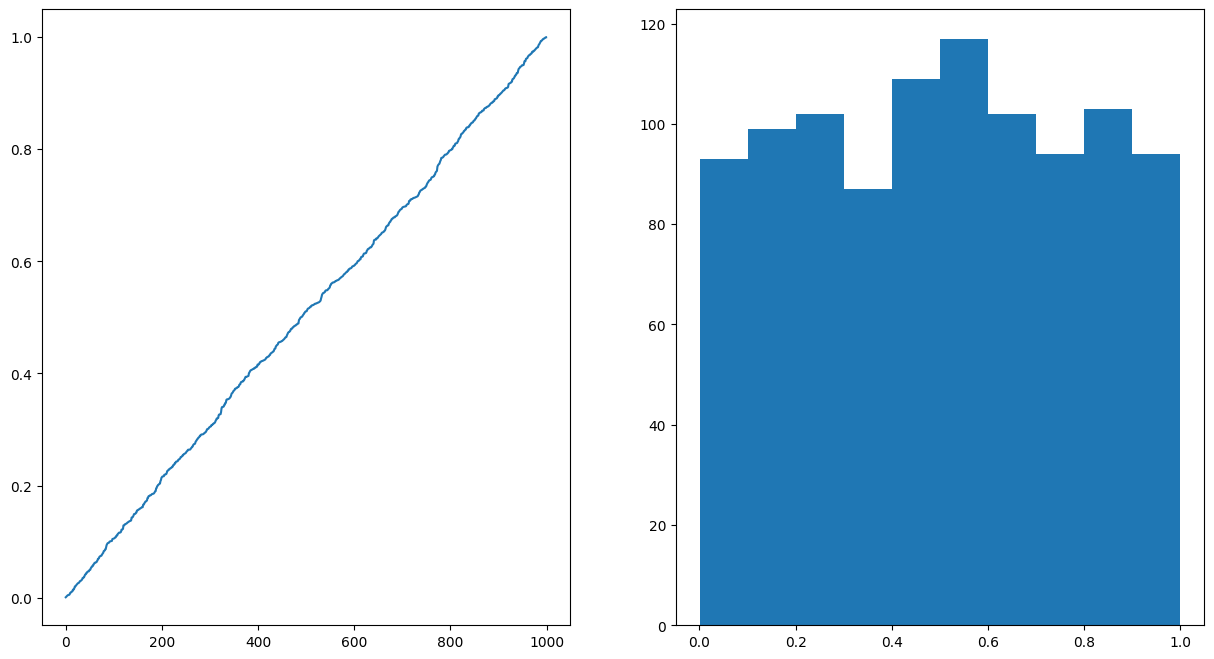

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.sort(x))
ax2.hist(x);

**Exercise:** put some other [distributions](https://numpy.org/doc/stable/reference/random/generator.html#distributions) into the code in one of the previous two slides and see what happens.

# Example: false positives

Suppose that I got a positive result on an HIV test. What’s the chance I am HIV positive?
(Here we really mean that “I” am a randomly chosen person from the US population.)

## Background data

The HIV rapid test has 99.4% specificity and 99.8% sensitivity.

Refreshing from [Wikipedia](https://en.wikipedia.org/wiki/Sensitivity_and_specificity),
specificity is the “true positive” rate and the sensitivity is the “true negative” rate:

- if you have HIV, the chance that it (wrongly) comes out negative is .006 = 0.6%;
- if you don’t have HIV, the chance that it (wrongly) comes out positive is .002 = .2%.

There are currently around
[1.2 million people with HIV in the US](https://www.hiv.gov/hiv-basics/overview/data-and-trends/statistics),
out of a total of [333 million](https://www.census.gov/popclock/),
giving an overall rate of 0.0036 = 0.36%.

In [4]:
true_pos = .994
true_neg = .998
pop_rate = 1.2 / 333

Answer 1: **simulation**

What is the proportion of people who got a positive test result who actually have HIV?

In [5]:
N = 1_000_000
hiv_status = [rng.uniform() < pop_rate for k in range(N)]
test_result = np.full((N,), "")
for k in range(N):
    if hiv_status[k]:
        if rng.uniform() < true_pos:
            result = "+"
        else:
            result = "-"
    else:
        if rng.uniform() < true_neg:
            result = "-"
        else:
            result = "+"
    test_result[k] = result

In [6]:
test_result[:10], hiv_status[:10]

(array(['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'], dtype='<U1'),
 [False, False, False, False, False, False, False, False, False, False])

In [7]:
test_result = pd.Series(test_result, name="test result")
hiv_status = pd.Series(hiv_status, name="HIV status")
pd.crosstab(test_result, hiv_status)

HIV status,False,True
test result,,
+,2007,3586
-,994393,14


In [8]:
3469/(1982+3469) # TODO: update based on simulation numbers (which change)

0.6363969913777289

Conclusion: only 63.6% of people with a positive test result
actually have HIV.

> Suppose that I got a positive result on an HIV test. What’s the chance I am HIV positive?

**Does this answer my question?**

*Next answer:* let's use math.

# Probability rules

(i.e., the *axioms of probability*)

## Probability rules

0. *Probabilities are proportions:* $\hspace{2em} 0 \le \P\{A\} \le 1$

1. *Everything:* $\hspace{2em} \P\{ \Omega \} = 1$

2. *Complements:* $\hspace{2em} \P\{ \text{not } A\} = 1 - \P\{A\}$

3. *Disjoint events:* If $\hspace{2em} \P\{A \text{ and } B\} = 0$
    then $\hspace{2em} \P\{A \text{ or } B\} = \P\{A\} + \P\{B\}$.

4. *Independence:* $A$ and $B$ are independent iff $\P\{A \text{ and } B\} = \P\{A\} \P\{B\}$.

5. *Conditional probability:* 
    $$\P\{A \;|\; B\} = \frac{\P\{A \text{ and } B\}}{ \P\{B\} }$$

## Bayes' rule

A consequence is that

$$\P\{B \;|\; A\} = \frac{\P\{B\} \P\{A \;|\; B\}}{ \P\{A\} } .$$

(*Example:* HIV test calculation, on the board.)

We want to know the proportion of people who got a positive test result who actually have HIV?

i.e.

What is the probability of getting a positive test result given that you have HIV
$$
  \mathbb{P}\{ B | A \} = 
$$
where we choose someone uniformly at random from the population,
and give them an HIV test, and
- $A$ is that they get a positive test result, and
- $B$ is that they have HIV.

What do we know? Well, the proportion of the population that has HIV is 0.0036
and the chance of getting a positive test result for someone with HIV is .994, 
and the chance of getting a positive test for someone *without* HIV is .998, so

- $\mathbb{P}\{A \text{ and } B\} = \mathbb{P}\{B\} \times \mathbb{P}\{A|B\} = 0.0036 \times .994$
- $\mathbb{P}\{A\} = \mathbb{P}\{A\text{ and }B\} + \mathbb{P}\{A\text{ and not }B\}
    = 0.0036 \times .994 + (1 - 0.0036) \times (1 - .998)$

In [9]:
num = pop_rate * true_pos
denom = num + (1 - pop_rate) * (1 - true_neg)
num / denom

0.6425339366515835